# Environment Setup

In [1]:
#!pip install gym_super_mario_bros
#!pip install stable_baselines3

In [2]:
# Import mario
import gym_super_mario_bros
# Import environment base class for a wrapper 
from gym import Env 
# Import the space shapes for the environment
from gym.spaces import Box
# Import simpler movements
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# Import to reduce number of movments
from nes_py.wrappers import JoypadSpace
# Import numpy to calculate frame delta 
import numpy as np
# Import opencv for grayscaling
import cv2

In [3]:
# Creating custom environment 
class Mario(Env): 
    
    def __init__(self):
        super().__init__()
        # Specify observation space 
        self.observation_space = Box(low=0, high=255, shape=(100, 100, 1), dtype=np.uint8)
        # Startup and instance of the game
        self.game = gym_super_mario_bros.make("SuperMarioBros-v0")
        
        
    def step(self, action): 
        # Take a step 
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs)
        
        # ***Reward shaping***       
        coins, flag_get, life, world = info["coins"], info["flag_get"], int(info["life"]), info["world"]
        status, time, x_pos, score  = info["status"], info["time"], info["x_pos"], info["score"]
        
        # Calculate reward deltas
        coins_delta = coins - self.coins
        self.coins = coins
        score_delta = score - self.score
        self.score = score
        lives_lost_delta = -self.life + life 
        self.life = life
        if status != 'small':
            big_boi_reward = 1.5
        else:
            big_boi_reward = 1
        if x_pos > self.x_pos:
            moving_forward_delta = x_pos - self.x_pos
            self.x_pos = x_pos
        else:
            moving_forward_delta = 0
            self.x_pos = self.x_pos
        
        reward = world * big_boi_reward * (score_delta + coins_delta*100 + flag_get*1000 + lives_lost_delta*5 + moving_forward_delta*0.1) + self.time_ticking*0.01

        return obs, reward, done, info
    
    
    def reset(self):
        # Return the first frame 
        obs = self.game.reset()
        obs = self.preprocess(obs) 
        self.previous_frame = obs 
        
        # Create game variables
        self.coins = 0
        self.flag_get = False
        self.life = 2
        self.stage = 1
        self.score = 0
        self.status = 'small'
        self.world = 1
        self.x_pos = 40
        self.time_ticking = -1
        
        return obs
    
    
    def preprocess(self, observation): 
        # Grayscaling 
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        # Resize 
        resize = cv2.resize(gray, (100,100), interpolation=cv2.INTER_CUBIC)
        # Add the channels value
        channels = np.reshape(resize, (100,100,1))
        return channels 
    
    
    def render(self, *args, **kwargs):
        self.game.render()
        
        
    def close(self):
        self.game.close()

# Testing Environment

C:\Users\mikol\anaconda3\envs\RL46\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


5.489999999999998
29.779999999999948
52.769999999999875
51.760000000000076
50.75000000000028
49.74000000000048
48.73000000000068
47.72000000000088
46.71000000000108
45.70000000000128
44.69000000000148
43.680000000001684


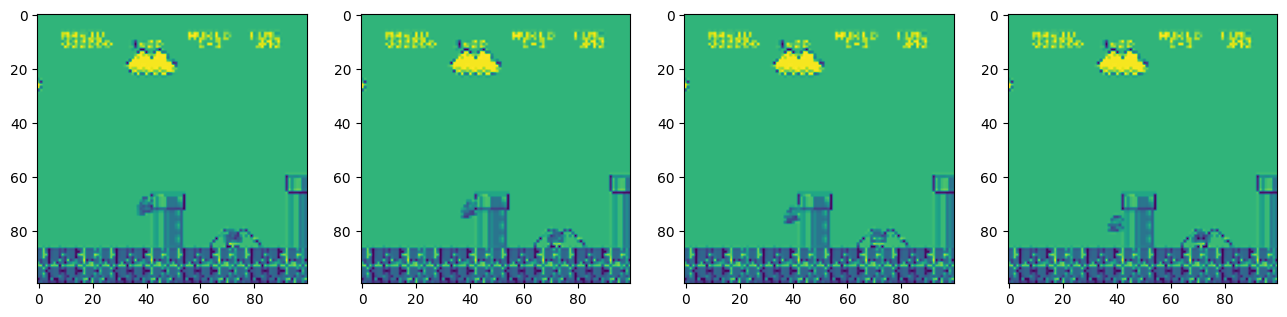

In [4]:
# Game with random actions

"""
# Importing sleep to slow down game
from time import sleep

# Creating environment
env = Mario()
env = JoypadSpace(env, SIMPLE_MOVEMENT)

obs = env.reset()
result = 0 

for i in range(1200):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    result += reward
    env.render()
    sleep(0.00002)
    i += 1
    if i % 100 == 0:
        result += reward
        print(result)
        
        
# Displaying preprocessed frames
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import matplotlib.pyplot as plt

env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

plt.figure(figsize=(16,9))

# Skipping some first black frames
for _ in range(6):
    obs, reward, done, info = env.step([env.action_space.sample()])
# Displaying 4 frames as movement
for i in range(obs.shape[3]):
    obs, reward, done, info = env.step([env.action_space.sample()])
    plt.subplot(1,4,i+1)
    plt.imshow(obs[0][:,:,i])
plt.show();
"""